# Optimal position size for the S&P500 using the Kelly criterion.

The Kelly criterion is a formula that determines the optimal size for a bet. It’s the position size that maximizes the expected growth rate of an account. John Kelly invented it in the 1950s and used it for gambling. In the 1960s, Edward Thorp popularized it in two famous books (Beat the Dealer and Beat the Market).

It was said that Warren Buffet and Bill Gross use versions of the Kelly criteria, too.

The Kelly criterion is valid when expected returns are known (it maximizes the expected growth rate). It also assumes you can make infinite bets. Most people can’t predict the returns of the stock market—or make infinite bets—and this can lead to ruin.

Which is a frequent (and justified) criticism.

In successful trading systems, however, you can estimate your expected returns by past system returns. If your trading system wins 60% of the time over hundreds (or thousands) of trades, there’s a good chance you’ll continue to win.

To show how you can use the Kelly criteria, you’ll find the optimal position size for the S&P500 index.

In [8]:
# Imports and set up

# Import the OpenBB SDK for data, NumPy for math, and SciPy for optimization.

%matplotlib inline
from openbb_terminal.sdk import openbb

import numpy as np

from scipy.optimize import minimize_scalar
from scipy.integrate import quad
from scipy.stats import norm
# Next, grab data for the S&P500 index. You can use portfolio returns, too.

annual_returns = (
    openbb.economy.index(
        ["^GSPC"],
        start_date="1950-01-01",
        column="Close"
    )
    .resample("A")
    .last()
    .pct_change()
    .dropna()
)

return_params = (
    annual_returns["^GSPC"]
    .rolling(25)
    .agg(["mean", "std"])
    .dropna()
)
# This grabs daily price data and resamples it to annual data taking the last value of the year. Then it computes the annual return. To estimate expected returns, take the mean and standard deviation.

annual_returns

,^GSPC
Date,
1951-12-31,0.163485
1952-12-31,0.117796
1953-12-31,-0.066240
1954-12-31,0.450222
1955-12-31,0.264036
...,...
2019-12-31,0.288781
2020-12-31,0.162589
2021-12-31,0.268927


In [9]:
return_params

,mean,std
Date,,
1975-12-31,0.076529,0.182985
1976-12-31,0.077649,0.183624
1977-12-31,0.068336,0.187369
1978-12-31,0.071410,0.185692
1979-12-31,0.058325,0.168628
1980-12-31,0.058073,0.168312
1981-12-31,0.053134,0.171076
1982-12-31,0.064764,0.167012
1983-12-31,0.056449,0.155404


In [3]:
# Compute the optimal position size

# You only need two functions to get the optimal position size with the Kelly criterion.

# Kelly defines the growth rate as the integral of the probability distribution of returns. The first function defines it.

def norm_integral(f, mean, std):
    val, er = quad(
        lambda s: np.log(1 + f * s) * norm.pdf(s, mean, std),
        mean - 3 * std,
        mean + 3 * std,
    )
    return -val

# This code integrates the function that Kelly defined as the probability distribution of returns. The function is integrated between -3 and 3 standard deviations. (The integral is the area under a function between two points.) Note this function returns the negative integral. That way you can optimize it by minimization in the next step.

In [4]:
# Next, solve for the optimal value that maximizes the expected return using SciPy (by minimizing the negative integral).

def get_kelly(data):
    solution = minimize_scalar(
        norm_integral,
        args=(data["mean"], data["std"]),
        bounds=[0, 2],
        method="bounded"
    )
    return solution.x
# SciPy’s minimize_scalar function finds the value that minimizes the negative integral. You bound it between 0 and 2 so your smallest bet is 0 and your maximum bet is 2x. This means it’s best to use leverage and buy the S&P500 index on margin.

<AxesSubplot:xlabel='Date'>

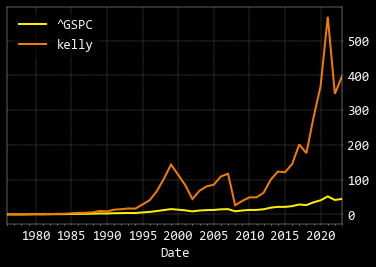

In [5]:
# Analyze the results

# Create the optimal Kelly value through time to see how well it performs against a single share in the S&P500 index.

annual_returns['f'] = return_params.apply(get_kelly, axis=1)
(
    annual_returns[["^GSPC"]]
    .assign(kelly=annual_returns["^GSPC"].mul(annual_returns.f.shift()))
    .dropna()
    .loc["1900":]
    .add(1)
    .cumprod()
    .sub(1)
    .plot(lw=2)
)

This chart shows how a portfolio performs over time by investing at the optimal position size described by the Kelly criterion. You can see it does pretty well!

You can use the Kelly criterion to help find the optimal position size when trading and investing. Make sure to take other risk metrics into consideration, too. Historic drawdown, volatility, and macroeconomic conditions are all popular.